# Mars Surface and Curiosity Image Classification
### Using a convolutional neural network
### Data Wrangling and Exploratory Analysis

by Zachary Pruessner, for Springboard Final submission

**Dataset DOI**

10.5281/zenodo.1049137

**Scientific Paper with additional details on the data** 

Kiri L. Wagstaff, You Lu, Alice Stanboli, Kevin Grimes, Thamme Gowda,
and Jordan Padams. "Deep Mars: CNN Classification of Mars Imagery for
the PDS Imaging Atlas." Proceedings of the Thirtieth Annual Conference
on Innovative Applications of Artificial Intelligence, 2018.


-

List of Labels


- 0       apxs
- 1       apxs cal target
- 2       chemcam cal target
- 3       chemin inlet open
- 4       drill
- 5       drill holes
- 6       drt front
- 7       drt side
- 8       ground
- 9       horizon
- 10      inlet
- 11      mahli
- 12      mahli cal target
- 13      mastcam
- 14      mastcam cal target
- 15      observation tray
- 16      portion box
- 17      portion tube
- 18      portion tube opening
- 19      rems uv sensor
- 20      rover rear deck
- 21      scoop
- 22      sun
- 23      turret
- 24      wheel

## Data Wrangling

### Imports

In [17]:
# Standard
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Pathing
import os

# Image Processing
import cv2
import matplotlib.image as mpimg

# Transformations
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Metrics

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

### Loading Data

In [3]:
# loading in the image path and label csv files
test = pd.read_csv('..\data\Test_CSV.csv')
train = pd.read_csv('..\data\Train_CSV.csv')
val = pd.read_csv('..\data\Validation_CSV.csv')

# displaying the layout of the tables
print(test.head(), '\n', train.head(), '\n',  val.head())

# checking the shape
print(' Test shape: ', test.shape, '\n', 'Train shape: ', train.shape, '\n', 'Val shape: ', val.shape )

                                             JPG  LABELS
0  calibrated/0830MR0036510000500684E01_DRCL.JPG       7
1  calibrated/0640MH0002640000203781I01_DRCL.JPG      24
2  calibrated/0647MH0003250050203806E01_DRCL.JPG       9
3  calibrated/0844MR0037590000501001I01_DRCL.JPG       7
4  calibrated/0618MR0026460020401253I01_DRCL.JPG      11 
                                              JPG  LABELS
0  calibrated/0077ML0005780000102730I01_DRCL.JPG      15
1  calibrated/0072MR0005610170103642E01_DRCL.JPG       8
2  calibrated/0069MR0004130000103477I01_DRCL.JPG      21
3  calibrated/0154ML0008510010104492E01_DRCL.JPG       8
4  calibrated/0019MR0000530000100138C00_DRCL.JPG       8 
                                              JPG  LABELS
0  calibrated/0292MH0002810020103587C00_DRCL.JPG       5
1  calibrated/0270MH0002530050102760I01_DRCL.JPG       5
2  calibrated/0549MH0002620000201566E01_DRCL.JPG      24
3  calibrated/0229MR0009720000202913E01_DRCL.JPG       0
4  calibrated/0292MH0002810

### Cleaning Data

The csv files only reference 6691 of the 39059 images available. These images reside in the images folder. The other 32368 reside in the folder labeled additional_images.

For now I will focus on using the images referenced in the tables.

Later on I will pursue an unsupervised approach using the remaining 39000 images.


The original data has the file paths set up for a different system. Therefore the file paths within the csv files will need to be corrected.

My folder structure is:
```
final_capstone
    |data
        |additional_images
        |images
    |dev
        |data_wrangling_eda_mccnn.ipynb
        |logs
    |dist
        |model
```

The new pathing will be '../data/images' followed by the image name

In [5]:
# helper function for correcting the pathing in the csv files
def modify_path(path_col, splitter='calibrated'):
    new_path_list = []
    for row in path_col:
        old_path, image_id = row.split(splitter)
        new_path = '../data/images' + str(image_id)
        new_path_list.append(new_path)
    return new_path_list

In [6]:
# reframing
frames = [train, test, val]

# joining into single df
mars = pd.concat(frames)
mars.shape

# using modify_path to correct the path values in the JPG column
mars['JPG'] = modify_path(mars['JPG'])

Now that the data has been corrected and merged, It will now be saved to a csv file for further use.

In [8]:
# saving dataframe to csv file
save_path = "../data/mars_merged.csv"

mars.to_csv(save_path, index=False)

### Exploratory Analysis

In [32]:
# setting aside some images to view
sample_img = mars['JPG'][:10]
sample_label = mars['LABELS'][:10]
print(sample_img)
print(sample_label)

0    ../data/images/0077ML0005780000102730I01_DRCL.JPG
1    ../data/images/0072MR0005610170103642E01_DRCL.JPG
2    ../data/images/0069MR0004130000103477I01_DRCL.JPG
3    ../data/images/0154ML0008510010104492E01_DRCL.JPG
4    ../data/images/0019MR0000530000100138C00_DRCL.JPG
5    ../data/images/0017ML0000500200100233B00_DRCL.JPG
6    ../data/images/0025MR0001230130100711E01_DRCL.JPG
7    ../data/images/0044MR0002011110102490E01_DRCL.JPG
8    ../data/images/0003ML0000000160100036I01_DRCL.JPG
9    ../data/images/0159MR0008640180201373E01_DRCL.JPG
Name: JPG, dtype: object
0    15
1     8
2    21
3     8
4     8
5     8
6     8
7     8
8     9
9     8
Name: LABELS, dtype: int64


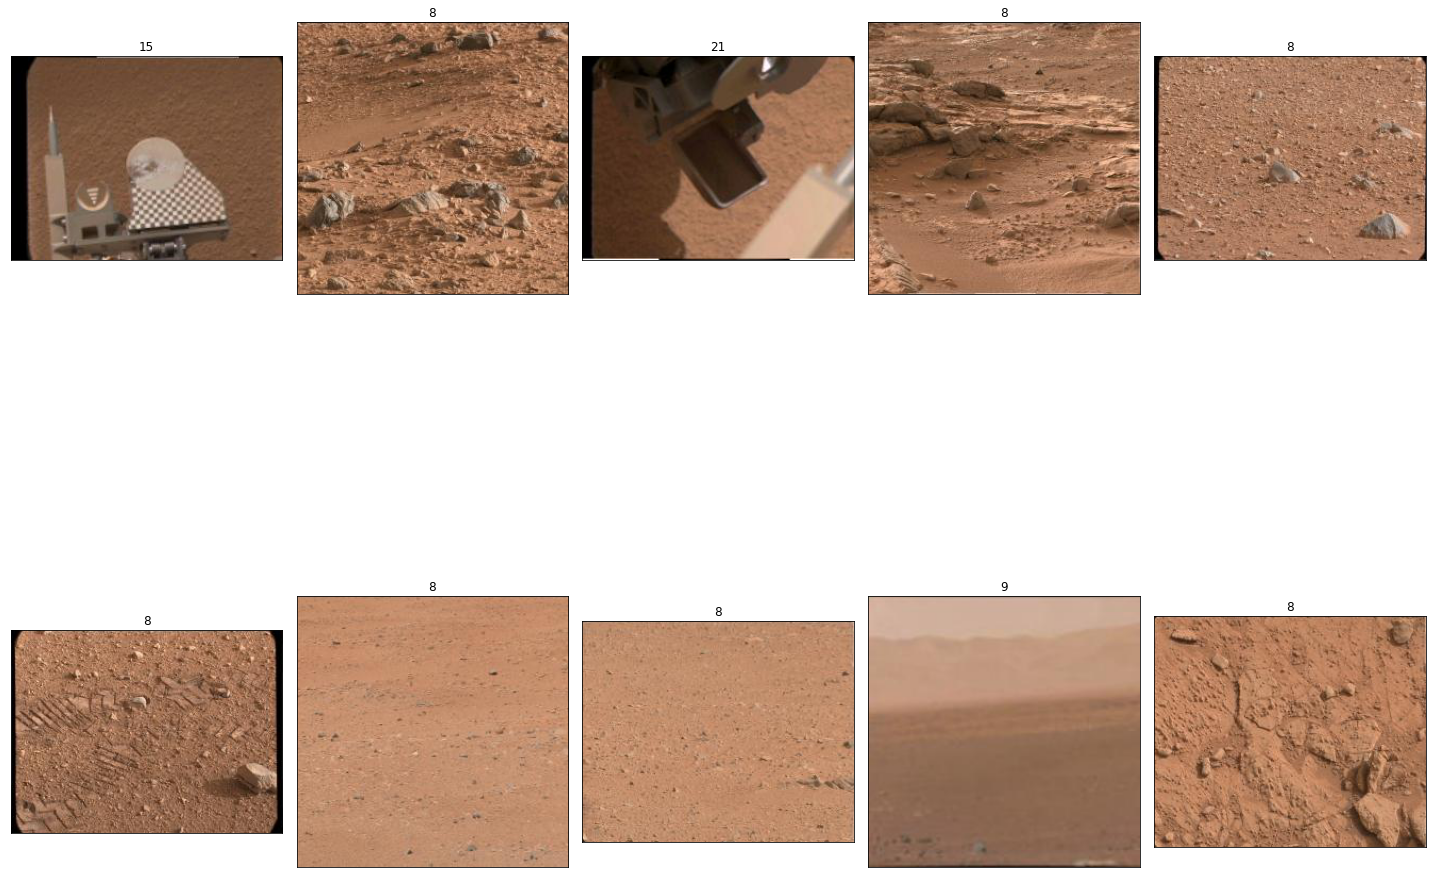

In [33]:
# visualizing the sample
fig, axes = plt.subplots(nrows=2,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})


for i, ax in enumerate(axes.flat):
    ax.imshow(mpimg.imread(sample_img[i]))
    ax.set_title(sample_label[i])
plt.tight_layout()
plt.show()

<AxesSubplot:>

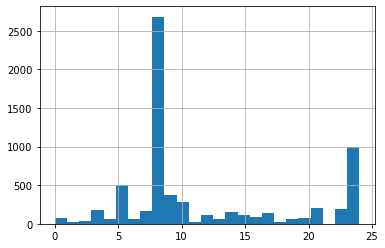

In [36]:
mars.LABELS.hist(bins=25)

The predominate label is 8(ground), with 24(wheel) in second.

One thing to note is the differing sizes in the image dataset. This will have to be corrected.

Additionally, all of the images will need to be normalized.